# Spacy

In [2]:
import json
import os
import sys
import numpy as np
from gensim.models import Word2Vec
# from keras.preprocessing import sequence
# from keras.layers import merge, Dense, Input,Dropout, Embedding, LSTM, Bidirectional, Activation
# from keras.layers import Conv2D,Conv1D
# from keras.layers.merge import dot, multiply, add, concatenate
# from keras.layers import Merge
# from keras.layers.core import Lambda,Reshape, Flatten, Dropout
# from keras.layers.pooling import GlobalMaxPooling2D, GlobalMaxPooling1D,MaxPooling1D
# from keras.models import Model
# from keras.backend import transpose,batch_dot,expand_dims
# from keras import optimizers
from HomeDepotCSVReader import HomeDepotReader
import Utilities
from DataPreprocessing import DataPreprocessing
from Feature_Word2Vec import Feature_Word2Vec
from AutomaticQueryExpansion import Word2VecQueryExpansion
import re
from nltk.corpus import stopwords
# from keras.utils.np_utils import to_categorical
import pandas as pd
from FeatureEngineering import HomeDepotFeature
# from keras.layers.wrappers import TimeDistributed
# from keras.callbacks import ModelCheckpoint,EarlyStopping

In [3]:
import spacy
#nlp = spacy.load('en')
#import en_vectors_glove_md
#nlp = en_vectors_glove_md.load()

nlp = spacy.load('en_core_web_md')


In [4]:
nlp.vocab.length

1340294

In [5]:
# train_filename = '../data/train_play.csv'
# test_filename = '../data/test_play.csv'
# soln_filename = '../data/solution.csv'
# attribute_filename = '../data/attributes_play.csv'
# description_filename = '../data/product_descriptions_play.csv'
# word2vec_model_path='model/word2vec_play.model'
# vocab_path='model/word2vec_play_vocab.json'
# embeddings_path='model/embeddings_play.npz'

train_filename = '../data/train.csv'
test_filename = '../data/test.csv'
soln_filename = '../data/solution.csv'
attribute_filename = '../data/attributes.csv'
description_filename = '../data/product_descriptions.csv'
word2vec_model_path='model/word2vec_cnn.model'
vocab_path='model/word2vec_cnn_vocab.json'
embeddings_path='model/embeddings_cnn.npz'
full_features_filename = '../data/features_full.csv'

In [6]:
reader = HomeDepotReader()

train_query_df, product_df, attribute_df, test_query_df = reader.getQueryProductAttributeDataFrame(train_filename,
                                              test_filename,
                                              attribute_filename,
                                              description_filename)
print("train_query_df:",list(train_query_df))
print("product_df:", list(product_df))
print("attribute_df:", list(attribute_df))
print("test_query_df:", list(test_query_df))

#transform attribute into doc
dp = DataPreprocessing()
attribute_doc_df = dp.getAttributeDoc(attribute_df)
#attribute_doc_df
product_df=product_df.join(attribute_doc_df.set_index('product_uid'), on = 'product_uid')
### test data
soln_df = pd.read_csv(soln_filename, delimiter=',', low_memory=False, encoding="ISO-8859-1")
test_private_df = dp.getGoldTestSet(test_query_df, soln_df, testsetoption='Private')#,savepath='../data/test_private_gold.csv')
test_public_df = dp.getGoldTestSet(test_query_df, soln_df, testsetoption='Public')# savepath='../data/test_public_gold.csv')

===========Tranforming labels...
showing current values
trainDF: ['id', 'product_uid', 'search_term', 'relevance']
trainDF:    id  product_uid    search_term  relevance
0   2       100001  angle bracket        3.0
self.mergedLabelDF: ['relevance'] 
 <class 'pandas.core.frame.DataFrame'> (74067, 1)    relevance
0        3.0
Old unique Labels: [ 1.    1.25  1.33  1.5   1.67  1.75  2.    2.25  2.33  2.5   2.67  2.75
  3.  ]
newLabels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12]
Creating new column for training:  relevance_int
===========Transform labels completed
train_query_df: ['id', 'product_uid', 'search_term', 'relevance', 'relevance_int', 'product_idx']
product_df: ['product_title', 'product_uid', 'product_description']
attribute_df: ['product_uid', 'name', 'value']
test_query_df: ['id', 'product_uid', 'search_term', 'product_idx']


# Content

In [7]:
# ## no attribute
product_df['content'] = product_df['product_title'].map(str) + ". " + \
                        product_df['product_description'].map(str) 
    
    


In [8]:
# attribute
product_df['content_attr'] = product_df['product_title'].map(str) + ". " + \
                        product_df['product_description'].map(str)  + ". " + \
                        product_df['attr_json'].map(str)

# Prev Features

In [9]:
feature_df = reader.getBasicDataFrame(full_features_filename)

In [10]:
feature_df.columns

Index(['id', 'product_idx', 'product_uid', 'relevance', 'relevance_int',
       'search_term', 'color_exist', 'brand_exist', 'wm_product_description',
       'wm_product_title', 'wm_product_brand', 'wm_attr_json',
       'Word2VecQueryExpansion', 'tfidf_product_title', 'tfidf_product_brand',
       'tfidf_product_description', 'tfidf_attr_json',
       'tfidf_expanded_product_title', 'tfidf_expanded_product_brand',
       'tfidf_expanded_product_description', 'tfidf_expanded_attr_json',
       'doc2vec_search_term_vector', 'doc2vec_product_title_vector',
       'doc2vec_product_title', 'doc2vec_product_brand_vector',
       'doc2vec_product_brand', 'doc2vec_product_description_vector',
       'doc2vec_product_description', 'doc2vec_attr_json_vector',
       'doc2vec_attr_json', 'doc2vec_Word2VecQueryExpansion_vector',
       'doc2vec_expanded_product_title', 'doc2vec_expanded_product_brand',
       'doc2vec_expanded_product_description', 'doc2vec_expanded_attr_json',
       'bm25', 'bm

# merged queries

In [11]:
all_queries_df = pd.concat([train_query_df,test_public_df,test_private_df])

In [12]:
all_queries_df.shape[0]

186134

# Investigate data

In [13]:
sns.countplot(x="relevance", data=train_query_df, palette="Greens") #palette="Greens_d")
plt.show()

NameError: name 'sns' is not defined

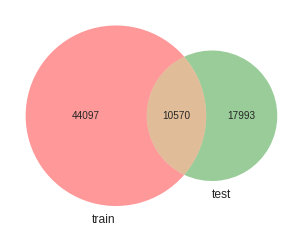

In [525]:
#Next, let’s see what percentage of products occur in train, test or both datasets:
# Using matplotlib_venn library: https://github.com/konstantint/matplotlib-venn
from matplotlib_venn import venn2
venn2([set(train_query_df["product_uid"]), set(test_public_df["product_uid"])],
    set_labels=('train', 'test'))
plt.show()

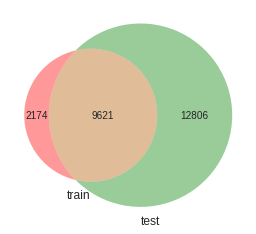

In [527]:
#And the same for queries:
# Using matplotlib_venn library: https://github.com/konstantint/matplotlib-venn
from matplotlib_venn import venn2
venn2([set(train_query_df["search_term"]), set(test_query_df["search_term"])],
    set_labels=('train', 'test'))
plt.show()

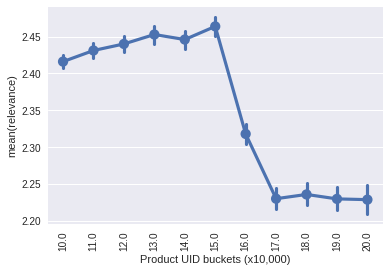

In [5]:
# Split products into buckets based on their product_uid
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.gcf()
#fig.set_size_inches(20,8)
train_query_df["product_uid_bucket"] = np.floor(train_query_df["product_uid"] / 10000)
# train_query_df["bucket"] = np.floor(train_query_df["product_uid"]\
#                                     [(train_query_df['product_uid'] > 160000) \
#                                     & (train_query_df['product_uid'] < 170000)] / 100)
sns.pointplot(x="product_uid_bucket", y="relevance", data=train_query_df[["product_uid_bucket", "relevance"]])
plt.xlabel('Product UID buckets (x10,000)')
plt.xticks(rotation=90)

plt.show()

# test_private_df["bucket"] = np.floor(test_private_df["product_uid"] / 1000)
# sns.pointplot(x="bucket", y="relevance", data=test_private_df[["bucket", "relevance"]])
# plt.show()

# Balanced data subsampling

In [563]:
#resample remove the low classes
resampled_train_query_df = train_query_df[train_query_df.relevance_int == 0]
min_samples=len(resampled_train_query_df)
for i in range(1,13):
    print(i)
    tmp_df = train_query_df[train_query_df.relevance_int == i]
    if len(tmp_df) > min_samples:
        tmp_df = tmp_df.ix[np.random.choice(tmp_df.index,min_samples)]
        resampled_train_query_df=pd.concat([resampled_train_query_df,tmp_df])

    else:
        print("removing {} as too few values {}".format(i,len(tmp_df)))

1
removing 1 as too few values 4
2
3
removing 3 as too few values 5
4
5
removing 5 as too few values 9
6
7
removing 7 as too few values 11
8
9
removing 9 as too few values 19
10
11
removing 11 as too few values 11
12


In [564]:
resampled_train_query_df

,id,product_uid,search_term,relevance,relevance_int,product_idx,bucket
17,69,100017,door guards,1.0,0,"Int64Index([11], dtype='int64')",100.0
49,178,100033,kitchen cabinet finishes,1.0,0,"Int64Index([21], dtype='int64')",100.0
56,195,100034,mortar tools,1.0,0,"Int64Index([22], dtype='int64')",100.0
217,696,100119,paint roller inserts,1.0,0,"Int64Index([87], dtype='int64')",100.0
226,734,100128,garage chair organizer,1.0,0,"Int64Index([93], dtype='int64')",100.0
230,742,100129,face masks,1.0,0,"Int64Index([94], dtype='int64')",100.0
242,764,100134,plastic covers,1.0,0,"Int64Index([99], dtype='int64')",100.0
270,867,100149,funnel 6 inch,1.0,0,"Int64Index([109], dtype='int64')",100.0
289,912,100152,foof leaf broom,1.0,0,"Int64Index([112], dtype='int64')",100.0
290,918,100152,lawn tractor,1.0,0,"Int64Index([112], dtype='int64')",100.0


# Product

In [111]:
product_idx=10

In [112]:
product_df['product_description'][product_idx]

'Make grilling great with this handsome and functional grill gazebo. This grill gazebo is a great gift to anyone who loves to grill, yourself included! Providing shade and protection from harmful UV rays, rain, and debris this grill gazebo will help keep your grill looking great and keep you cool when grilling in the hot summer sun. This grill gazebo comes with a rich brown canopy and black frame. Its 8 foot width means that you can easily fit most size grills beneath, and standing at 8 feet tall even the tallest grill afficionado will fit beneath comfortably! Upgrade your grilling today with the addition of this stunning grill gazebo!Vented canopyBuilt in lattice work is great for holding grill accessories2 built in tile shelvesVersatile design will coordinate easilyDurable, powder coated finishLow maintenance, easy to clean'

In [113]:
product_df['product_uid'][product_idx]

100016

In [114]:
document = nlp(product_df['product_description'][product_idx])

In [115]:
list(document.sents)

[Make grilling great with this handsome and functional grill gazebo.,
 This grill gazebo is a great gift to anyone who loves to grill, yourself included!,
 Providing shade and protection from harmful UV rays, rain, and debris this grill gazebo will help keep your grill looking great and keep you cool when grilling in the hot summer sun.,
 This grill gazebo comes with a rich brown canopy and black frame.,
 Its 8 foot width means that you can easily fit most size grills beneath, and standing at 8 feet tall even the tallest grill afficionado will fit beneath comfortably! Upgrade your grilling today with the addition of this stunning grill gazebo!Vented canopyBuilt in lattice work is great for holding grill accessories2 built in tile shelvesVersatile design will coordinate easilyDurable, powder coated finishLow maintenance, easy to clean]

In [116]:
all_tags = {w.pos: w.pos_ for w in document}

In [117]:
all_tags

{82: 'ADJ',
 83: 'ADP',
 84: 'ADV',
 87: 'CCONJ',
 88: 'DET',
 90: 'NOUN',
 91: 'NUM',
 92: 'PART',
 93: 'PRON',
 94: 'PROPN',
 95: 'PUNCT',
 98: 'VERB'}

In [118]:
def cleanup(token, lower = True):
    if lower:
        token = token.lower()
    return token.strip()

In [119]:
labels = set([w.label_ for w in document.ents]) 
for label in labels: 
    entities = [cleanup(e.string, lower=False) for e in document.ents if label==e.label_] 
    entities = list(set(entities)) 
    print(label,entities)

CARDINAL ['8']
DATE ['today']
GPE ['Upgrade']
QUANTITY ['8 feet']
ORG ['UV']


In [166]:
labels

{'CARDINAL', 'DATE', 'GPE', 'LOC', 'ORG', 'QUANTITY'}

In [167]:
for noun_phrase in document.noun_chunks:
    print("{} : {} : {}".format(noun_phrase.text, noun_phrase.root.dep_, noun_phrase.root.head.text))

your bathroom : dobj : Update
the Delta Vero Single-Handle Shower Faucet Trim Kit : pobj : with
Chrome : pobj : in
It : nsubj : has
The MultiChoice universal valve : nsubj : keeps
the water temperature : dobj : keeps
+/-3 degrees : pobj : within
scalding : dobj : prevent
California residents : nsubjpass : turned
the trim kit : dobj : informationIncludes
kit : pobj : in
separatelyIncludes : dobj : sold
hot and cold water : pobj : of
a valve : nsubjpass : turned
the systemDue : pobj : in
WaterSense regulations : pobj : to
the state : pobj : in
New York : pobj : of
your shipping zip code : dobj : confirm
use : pobj : from
items : pobj : of
WaterSense qualifications : dobj : meet


# query

In [168]:
train_query_df

,id,product_uid,search_term,relevance,relevance_int,product_idx
0,2,100001,angle bracket,3.00,12,"Int64Index([0], dtype='int64')"
1,3,100001,l bracket,2.50,9,"Int64Index([0], dtype='int64')"
2,9,100002,deck over,3.00,12,"Int64Index([1], dtype='int64')"
3,16,100005,rain shower head,2.33,8,"Int64Index([2], dtype='int64')"
4,17,100005,shower only faucet,2.67,10,"Int64Index([2], dtype='int64')"
5,18,100006,convection otr,3.00,12,"Int64Index([3], dtype='int64')"
6,20,100006,microwave over stove,2.67,10,"Int64Index([3], dtype='int64')"
7,21,100006,microwaves,3.00,12,"Int64Index([3], dtype='int64')"
8,23,100007,emergency light,2.67,10,"Int64Index([4], dtype='int64')"
9,27,100009,mdf 3/4,3.00,12,"Int64Index([5], dtype='int64')"


In [195]:
query_df=train_query_df[train_query_df['product_idx'] == 2]
for query_row in query_df.itertuples():    
    query=query_row.search_term
    relevance=query_row.relevance
    print("{} : {}".format(query,relevance))
    


rain shower head : 2.33
shower only faucet : 2.67


In [196]:
query = nlp('shower only faucet')

In [283]:
query.doc.similarity(query)
for w in query:
    print(w.lower_)

angle
bracket


# noun keyword counts

In [10]:
def count_noun_chunks_overlap(query,doc):
    #TODO add types
    #TODO, similarity metric too

#     for noun_phrase in query.noun_chunks:
#         print("query: {} : {} : {}".format(noun_phrase.text, noun_phrase.root.dep_, noun_phrase.root.head.text))
#     for noun_phrase in doc.noun_chunks:
#         print("doc  : {} : {} : {}".format(noun_phrase.text, noun_phrase.root.dep_, noun_phrase.root.head.text))
#     print("=")

    overlap_count=0
    noun_chunks_count=0
    #processed_noun_chunks_dep=[]
    matching_noun_chunks_dep=[]
    for query_noun_phrase in query.noun_chunks:
        for noun_phrase in doc.noun_chunks:
            #if str(noun_phrase)+':'+str(noun_phrase.root.dep_) not in processed_noun_chunks_dep and (noun_phrase.root.dep_ == 'pobj' or noun_phrase.root.dep_ == 'ROOT'):   #nsubj
            if noun_phrase.root.dep_ == 'ROOT' or noun_phrase.root.dep_ == 'pobj':# or    #nsubj
                for n in noun_phrase.lower_.split():
                    for q_word in query_noun_phrase.lower_.split():
                        #print("wrod {}".format({word}))
                        if n == q_word:
                            #print("wordlower  : {} : {} : {}".format(noun_phrase.text, noun_phrase.root.dep_, noun_phrase.root.head.text))
                            overlap_count+=1
                            matching_noun_chunks_dep+=[str(noun_phrase)+':'+str(noun_phrase.root.dep_)]
                for n in noun_phrase.lemma_.split():
                    for q_word in query_noun_phrase.lemma_.split():
                        #print("wrod {}".format({word}))
                        if n == q_word:
                            #print("wordlemma  : {} : {} : {}".format(noun_phrase.text, noun_phrase.root.dep_, noun_phrase.root.head.text))
                            overlap_count+=1
                            matching_noun_chunks_dep+=[str(noun_phrase)+':'+str(noun_phrase.root.dep_)]
            noun_chunks_count+=1
            #processed_noun_chunks_dep+=[str(noun_phrase)+':'+str(noun_phrase.root.dep_)]
#     print("=====================")
#     print(set(matching_noun_chunks_dep))
#     print("=====================")
    return (overlap_count,noun_chunks_count,len(set(matching_noun_chunks_dep)))
    #return (len(set(matching_noun_chunks_dep)),noun_chunks_count)

#                 print(word.lower_)
#                 print(word.lemma_)
#                 if word.lower_ == n.lower():
#                     print("wordlower  : {} : {} : {}".format(noun_phrase.text, noun_phrase.root.dep_, noun_phrase.root.head.text))
#                 if word.lemma_ == n.lemma_:
#                     print("wordlemma  : {} : {} : {}".format(noun_phrase.text, noun_phrase.root.dep_, noun_phrase.root.head.text))
def query_doc_similarity(query,doc):
    print("qd_similarity: {}".format(query.doc.similarity(doc)))
    

In [11]:
query=nlp(str(train_query_df.iloc[0].search_term))
doc=nlp(str(product_df.iloc[0].content_attr))
count_noun_chunks_overlap(query,doc)

(1, 37, 1)

In [39]:
product_uid=int(feature_df.iloc[100].product_uid)
print(product_uid)
product_idx=product_df[product_df['product_uid'] == product_uid]['content_attr'].index[0] #feature_df workaround
str(product_df.iloc[product_idx]['content_attr'])

100058


"Gama Sonic 40-LED Rechargeable Battery-Powered Emergency Lantern. This rechargeable emergency lamp is a must have in every home. It has an AC/DC charger and turns on automatically when the power goes out. It has 40 bright white LED bulbs and a 7 hour run time. It also has an easy carry handle. Don't be in the dark anymore when the power goes out.Turns on automatically when the power goes out7 hour run time on full chargeManual on/off switchFoldable carry handle40 LEDs with output of 300 LumensHome Depot Protection Plan:. {'Battery Life (hours)': '7', 'Battery Size': nan, 'Bulb Type': 'LED', 'Bullet01': 'Turns on automatically when the power goes out', 'Bullet02': '7 hour run time on full charge', 'Bullet03': 'Manual on/off switch', 'Bullet04': 'Foldable carry handle', 'Bullet05': '40 LEDs with output of 300 Lumens', 'Casing material': 'Plastic', 'Charger Included': 'Yes', 'Color': 'White', 'Color Family': 'Whites', 'Flashlight Features': 'Rechargeable', 'Flashlight type': 'Lantern', '

In [46]:
i=0
relevances=[]
overlap_counts=[]
overlap_ratios=[]
uniq_overlap_counts=[]
#for query_row in train_query_df[train_query_df['relevance']>=1].itertuples():    
#for query_row in resampled_train_query_df[resampled_train_query_df['relevance']>=1].itertuples():    
for feature_row in feature_df.itertuples():    
    uniq_id=int(feature_row.id) # feature_df workaround    
    query_row = all_queries_df[all_queries_df.id == uniq_id] # feature_df workaround
    if len(query_row) > 0:
        query=nlp(str(query_row.search_term)) 
        relevance=query_row.relevance
        product_uid=int(query_row.product_uid)
        #product_idx=query_row.product_idx.values[0]
        product_idx=product_df[product_df['product_uid'] == product_uid]['content_attr'].index[0] #feature_df workaround
        doc=nlp(str(product_df.iloc[product_idx]['content_attr']))
        #print("======")
        #print("{} : {} : {}".format(query,product_uid,relevance))
        overlap_count,noun_chunks_count,uniq_overlap_count=count_noun_chunks_overlap(query,doc)
        if noun_chunks_count == 0:
            overlap_ratio = 0 
        else:
            overlap_ratio = overlap_count/noun_chunks_count
        #print("==== {} {} {} ".format(overlap_count, noun_chunks_count , overlap_ratio))
        overlap_counts+=[overlap_count]
        uniq_overlap_counts+=[uniq_overlap_count]
        overlap_ratios+=[overlap_ratio]
        relevances+=[relevance]
        #query_doc_similarity(query,doc) #10 samples not good.
#         print(list(query.sents))
#         print(list(doc.sents))
    i+=1
    if i % 100 == 0: #print every 100 
        print(i)
#     if i >= 5:
#         break

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
1850

In [93]:
## feature_df add this back to df and dump to file
print(len(overlap_counts))
print(len(overlap_ratios))
print(len(uniq_overlap_counts))

ref_index=feature_df.join(all_queries_df.set_index('id'),on='id',how='inner',lsuffix='_caller', rsuffix='_other').index

print(len(ref_index))
# for feature_row in feature_df.itertuples():    
#     uniq_id=int(feature_row.id) # feature_df workaround    
#     query_row = all_queries_df[all_queries_df.id == uniq_id] # feature_df workaround
#     if len(query_row) > 0:

186134
186134
186134
186134


In [95]:
ref_index

Int64Index([     0,      1,      2,      3,      4,      5,      6,      7,
                 8,      9,
            ...
            221458, 221459, 221461, 221466, 221467, 221468, 221469, 221470,
            221471, 221472],
           dtype='int64', length=186134)

In [96]:
#noun_overlaps_df = pd.DataFrame([[overlap_counts],[uniq_overlap_counts],[overlap_ratios]],columns=['noun_overlap_counts','noun_unique_overlap_counts','noun_overlap_ratios'],index=ref_index)

noun_overlap_counts_df = pd.DataFrame(overlap_counts,columns=['noun_overlap_counts'],index=ref_index)
noun_uniq_overlap_counts_df = pd.DataFrame(uniq_overlap_counts,columns=['noun_uniq_overlap_counts'],index=ref_index)
noun_overlap_ratios_df = pd.DataFrame(overlap_ratios,columns=['noun_overlap_ratios'],index=ref_index)

In [97]:
nouns_df = pd.concat([noun_overlap_counts_df,noun_uniq_overlap_counts_df,noun_overlap_ratios_df],axis=1)

In [98]:
nouns_df

,noun_overlap_counts,noun_uniq_overlap_counts,noun_overlap_ratios
0,1,1,0.027027
1,0,0,0.000000
2,8,3,0.068966
3,4,2,0.080000
4,12,3,0.240000
5,4,2,0.008299
6,22,5,0.022822
7,5,4,0.020747
8,2,1,0.035088
9,8,3,0.235294


In [99]:
new_feature_df = pd.concat([feature_df,nouns_df],axis=1)

In [107]:
new_feature_df[['noun_overlap_counts','noun_uniq_overlap_counts','noun_overlap_ratios']] = \
    new_feature_df[['noun_overlap_counts','noun_uniq_overlap_counts','noun_overlap_ratios']].fillna(value=0)

In [108]:
new_feature_df

,id,product_idx,product_uid,relevance,relevance_int,search_term,color_exist,brand_exist,wm_product_description,wm_product_title,...,doc2vec_expanded_attr_json,bm25,bm25expandedquery,len_product_title,len_product_description,len_brand,len_search_term,noun_overlap_counts,noun_uniq_overlap_counts,noun_overlap_ratios
0,2,"Int64Index([0], dtype='int64')",100001,3.00,12.0,angl bracket,0,0,1.298530,1.065446,...,0.188647,0.000000,0.000000,6,102,3,2,1.0,1.0,0.027027
1,3,"Int64Index([0], dtype='int64')",100001,2.50,9.0,l bracket,0,0,1.328475,1.308964,...,0.195774,0.000000,0.000000,6,102,3,2,0.0,0.0,0.000000
2,9,"Int64Index([1], dtype='int64')",100002,3.00,12.0,deck,0,0,1.296529,1.195929,...,0.187528,0.000000,0.000000,12,128,4,1,8.0,3.0,0.068966
3,16,"Int64Index([2], dtype='int64')",100005,2.33,8.0,rain shower head,0,0,1.291264,1.195568,...,0.233663,0.010415,0.010415,11,78,1,3,4.0,2.0,0.080000
4,17,"Int64Index([2], dtype='int64')",100005,2.67,10.0,shower faucet,0,0,1.261110,1.053995,...,0.202693,0.000000,0.000000,11,78,1,2,12.0,3.0,0.240000
5,18,"Int64Index([3], dtype='int64')",100006,3.00,12.0,convect otr,0,0,1.309936,1.161724,...,0.222768,0.010984,0.010984,12,346,1,2,4.0,2.0,0.008299
6,20,"Int64Index([3], dtype='int64')",100006,2.67,10.0,microwav stove,0,0,1.246113,1.136269,...,0.335094,0.000000,0.000000,12,346,1,2,22.0,5.0,0.022822
7,21,"Int64Index([3], dtype='int64')",100006,3.00,12.0,microwav,0,0,1.303795,1.250717,...,0.506756,0.000000,0.000000,12,346,1,1,5.0,4.0,0.020747
8,23,"Int64Index([4], dtype='int64')",100007,2.67,10.0,emerg light,0,0,1.253217,1.032900,...,0.304746,0.000000,0.000000,10,103,2,2,2.0,1.0,0.035088
9,27,"Int64Index([5], dtype='int64')",100009,3.00,12.0,mdf 3 4,0,0,1.218341,0.855045,...,0.184559,0.000000,0.000000,14,60,3,3,8.0,3.0,0.235294


In [109]:
pd.DataFrame(new_feature_df).to_csv('../data/features_full_plusnouns.csv', \
                                    index=False, header=True)

In [513]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# plt.scatter(overlap_ratios,relevances)
# plt.show()

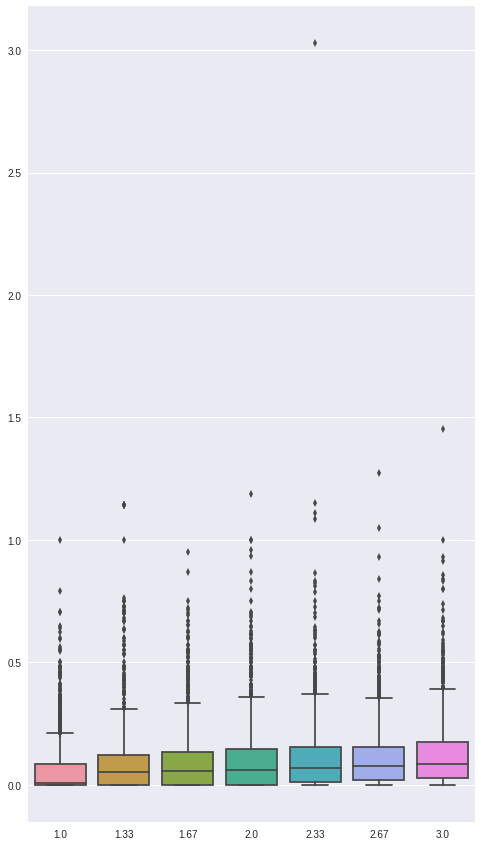

In [612]:
fig = plt.gcf()
fig.set_size_inches(8,15)
#sns.stripplot(relevances,overlap_ratios,jitter=True, alpha=.40)
#sns.pointplot(relevances,overlap_ratios,jitter=True, alpha=.40)
sns.boxplot(relevances,overlap_ratios)
#sns.despine()

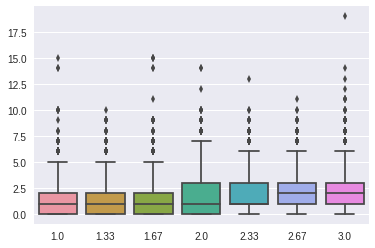

In [596]:
#plt.scatter(overlap_counts,relevances)
#sns.stripplot(relevances,uniq_overlap_counts,jitter=True, alpha=.40)
#sns.pointplot(relevances,uniq_overlap_counts,jitter=True, alpha=.40)
sns.boxplot(relevances,uniq_overlap_counts)
#sns.despine()

fig = plt.gcf()
fig.set_size_inches(8,10)
#plt.scatter(overlap_counts,relevances)
#sns.stripplot(relevances,overlap_counts,jitter=True, alpha=.40)
#sns.pointplot(relevances,overlap_counts,jitter=True, alpha=.40)
sns.boxplot(relevances,overlap_counts)
#sns.despine()

# Entities

In [ ]:
i=0
relevances=[]
overlap_counts=[]
overlap_ratios=[]
uniq_overlap_counts=[]
#for query_row in train_query_df[train_query_df['relevance']>=1].itertuples():    
#for query_row in resampled_train_query_df[resampled_train_query_df['relevance']>=1].itertuples():    
for feature_row in feature_df.itertuples():    
    uniq_id=int(feature_row.id) # feature_df workaround    
    query_row = all_queries_df[all_queries_df.id == uniq_id] # feature_df workaround
    if len(query_row) > 0:
        query=nlp(str(query_row.search_term)) 
        relevance=query_row.relevance
        product_uid=int(query_row.product_uid)
        #product_idx=query_row.product_idx.values[0]
        product_idx=product_df[product_df['product_uid'] == product_uid]['content_attr'].index[0] #feature_df workaround
        doc=nlp(str(product_df.iloc[product_idx]['content_attr']))
        #print("======")
        #print("{} : {} : {}".format(query,product_uid,relevance))
        overlap_count,noun_chunks_count,uniq_overlap_count=count_noun_chunks_overlap(query,doc)
        if noun_chunks_count == 0:
            overlap_ratio = 0 
        else:
            overlap_ratio = overlap_count/noun_chunks_count
        #print("==== {} {} {} ".format(overlap_count, noun_chunks_count , overlap_ratio))
        overlap_counts+=[overlap_count]
        uniq_overlap_counts+=[uniq_overlap_count]
        overlap_ratios+=[overlap_ratio]
        relevances+=[relevance]
        #query_doc_similarity(query,doc) #10 samples not good.
#         print(list(query.sents))
#         print(list(doc.sents))
    i+=1
    if i % 100 == 0: #print every 100 
        print(i)
#     if i >= 5:
#         break

In [157]:
document = nlp(product_df['content'][101])

In [158]:
list(document.sents)

[Philips 4 ft.,
 T8 32-Watt Daylight (6500K) ALTO Linear Fluorescent Light Bulb (10-Pack).,
 Create a cool and refreshing environment with the Philips 32-Watt 4 ft.,
 T8 Daylight Linear Alto Fluorescent Light Bulbs (10-Pack).,
 These light bulbs cast an arctic white light making them ideal for bathrooms, laundry rooms or any room.,
 The long-lasting bulbs can shine up to 30,000 hours using 2,850 Lumens.,
 These bulbs feature Alto low-mercury technology for environmentally friendly use.,
 Brightness: 2850 LumensEstimated yearly energy cost: $3.85 (based on 3 hours/day 11/kWh.,
 cost depend on rates and use)Life: 27.4 years (based on 3 hours/day)Light appearance: 6500K (daylight)Energy used: 32-WattLumens per Watt: 89.06Great for indoor, commercial and residential useCasts an arctic white light perfect for commercial or residential general purpose use in bathrooms, laundry rooms or kitchensT8, bi-pinFluorescent lamp with alto technology has reduced mercury content for an environmentally 

In [159]:
labels = set([w.label_ for w in document.ents]) 
for label in labels: 
    entities = [cleanup(e.string, lower=False) for e in document.ents if label==e.label_] 
    entities = list(set(entities)) 
    print(label,entities)

CARDINAL ['up to 30,000', '6500', '2,850', '89.06Great', '32-WattLumens', '3', '2850', '11/kWh']
DATE ['yearly', '27.4 years']
MONEY ['$3.85']
QUANTITY ['4 ft']
PRODUCT ['32-Watt']
ORG ['Philips', 'Lumens.', 'T8 Daylight', 'ALTO Linear Fluorescent Light Bulb', 'Philips 4', 'Alto']
EVENT ['T8 32-Watt Daylight']


,relevance
count,56.000000
mean,2.524107
std,0.508155
min,1.000000
25%,2.000000
50%,2.670000
75%,3.000000
max,3.000000


# Product_uid binary

In [212]:
#queries = train_query_df[['search_term','relevance']][train_query_df['product_uid'] == product_df.iloc[101].product_uid ]
queries = train_query_df[['search_term','relevance']][(train_query_df['product_uid'] > 163200) & (train_query_df['product_uid'] < 163300) ]

In [213]:
queries.describe()

,relevance
count,56.000000
mean,2.524107
std,0.508155
min,1.000000
25%,2.000000
50%,2.670000
75%,3.000000
max,3.000000


In [214]:
def product_uid_threshold(row):
    if row.product_uid < 163100:
        return 1
    else:
        return 0

In [215]:
new_feature_df['product_uid_threshold'] = new_feature_df.apply (lambda row: product_uid_threshold (row),axis=1)

In [216]:
new_feature_df

,id,product_idx,product_uid,relevance,relevance_int,search_term,color_exist,brand_exist,wm_product_description,wm_product_title,...,bm25,bm25expandedquery,len_product_title,len_product_description,len_brand,len_search_term,noun_overlap_counts,noun_uniq_overlap_counts,noun_overlap_ratios,product_uid_threshold
0,2,"Int64Index([0], dtype='int64')",100001,3.00,12.0,angl bracket,0,0,1.298530,1.065446,...,0.000000,0.000000,6,102,3,2,1.0,1.0,0.027027,1
1,3,"Int64Index([0], dtype='int64')",100001,2.50,9.0,l bracket,0,0,1.328475,1.308964,...,0.000000,0.000000,6,102,3,2,0.0,0.0,0.000000,1
2,9,"Int64Index([1], dtype='int64')",100002,3.00,12.0,deck,0,0,1.296529,1.195929,...,0.000000,0.000000,12,128,4,1,8.0,3.0,0.068966,1
3,16,"Int64Index([2], dtype='int64')",100005,2.33,8.0,rain shower head,0,0,1.291264,1.195568,...,0.010415,0.010415,11,78,1,3,4.0,2.0,0.080000,1
4,17,"Int64Index([2], dtype='int64')",100005,2.67,10.0,shower faucet,0,0,1.261110,1.053995,...,0.000000,0.000000,11,78,1,2,12.0,3.0,0.240000,1
5,18,"Int64Index([3], dtype='int64')",100006,3.00,12.0,convect otr,0,0,1.309936,1.161724,...,0.010984,0.010984,12,346,1,2,4.0,2.0,0.008299,1
6,20,"Int64Index([3], dtype='int64')",100006,2.67,10.0,microwav stove,0,0,1.246113,1.136269,...,0.000000,0.000000,12,346,1,2,22.0,5.0,0.022822,1
7,21,"Int64Index([3], dtype='int64')",100006,3.00,12.0,microwav,0,0,1.303795,1.250717,...,0.000000,0.000000,12,346,1,1,5.0,4.0,0.020747,1
8,23,"Int64Index([4], dtype='int64')",100007,2.67,10.0,emerg light,0,0,1.253217,1.032900,...,0.000000,0.000000,10,103,2,2,2.0,1.0,0.035088,1
9,27,"Int64Index([5], dtype='int64')",100009,3.00,12.0,mdf 3 4,0,0,1.218341,0.855045,...,0.000000,0.000000,14,60,3,3,8.0,3.0,0.235294,1


In [217]:
pd.DataFrame(new_feature_df).to_csv('../data/features_full_plusnouns_pluspuidthresh.csv', \
                                    index=False, header=True)